In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, ReLU, MaxPool2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential

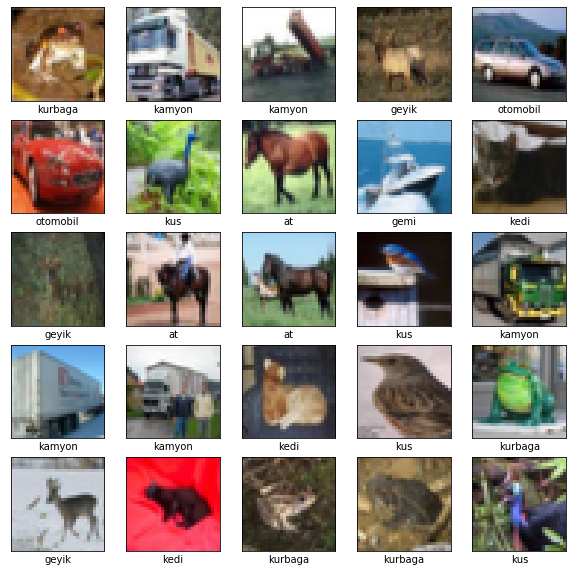

In [2]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

train_labels = train_labels.reshape((-1,))
test_labels = test_labels.reshape((-1,))

class_names = ['ucak', 'otomobil', 'kus', 'kedi', 'geyik',
               'kopek', 'kurbaga', 'at', 'gemi', 'kamyon']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [3]:
data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=50000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.astype(np.int32))).batch(1000)

In [22]:
train_steps = 1000
input_dim = (32, 32, 3)

#CNN Architecture

conv_filters = [32, 32, 64, 64, 128, 128]
conv_kernel_size = [3, 3, 3, 3, 3, 3]
conv_strides = [1, 1, 1, 1, 1, 1]
max_pool = [False, True, False, True, False, False]

use_batch_norm = True
use_dropout = True


model = Sequential()


model.add(Input(shape=(input_dim), name='input'))

for i in range(len(conv_filters)):
    
    conv_layer = Conv2D(
        filters = conv_filters[i]
        , kernel_size = conv_kernel_size[i]
        , strides = conv_strides[i]
        , padding = 'same'
        , name = 'conv_' + str(i)
        )

    model.add(conv_layer)
    
    if max_pool[i]:
        model.add(MaxPool2D(pool_size=(2, 2), padding="same"))
    
    model.add(ReLU())

    if use_batch_norm:
        model.add(BatchNormalization())

    if use_dropout:
         model.add(Dropout(rate = 0.25))


model.add(Flatten())
model.add(Dense(10, name='cnn_output'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
re_lu_7 (ReLU)               (None, 16, 16, 32)       

In [24]:
opt = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

logdir = os.path.join("logs", "cifar" + str(time.time()))
train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))


for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)
    
    with train_writer.as_default():
        tf.summary.scalar("loss", xent, step=step)
    
    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
      
    opt.apply_gradients(zip(grads, varis))
    
    
    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        
        acc = train_acc_metric.result()
        
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()
        with train_writer.as_default():
            tf.summary.scalar("accuracy", acc, step=step) 

Loss: 2.3037593364715576 Accuracy: 0.109375
Loss: 1.6887465715408325 Accuracy: 0.3828125
Loss: 1.3857805728912354 Accuracy: 0.5
Loss: 0.9920865297317505 Accuracy: 0.609375
Loss: 1.1063374280929565 Accuracy: 0.6328125
Loss: 1.11210298538208 Accuracy: 0.6015625
Loss: 0.8913034200668335 Accuracy: 0.671875
Loss: 0.9596055746078491 Accuracy: 0.671875
Loss: 0.6536492109298706 Accuracy: 0.78125
Loss: 0.8282619118690491 Accuracy: 0.71875
Loss: 0.6339554786682129 Accuracy: 0.7421875


In [25]:
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))
print("Test acc: {}".format(test_acc_metric.result()))

Test acc: 0.7458999752998352
